Let's explore the last-layer embeddings in the QMIA model on C10 with Class 1 (automobile) held out.

In [ ]:
import argparse
import os
import time

import torch
import numpy as np
import random

from lightning_utils import LightningQMIA
from data_utils import CustomDataModule
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import pytorch_lightning as pl

os.environ["CUDA_VISIBLE_DEVICES"]="4 5 6 7"

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ("yes", "true", "t", "y", "1"):
        return True
    elif v.lower() in ("no", "false", "f", "n", "0"):
        return False
    else:
        raise argparse.ArgumentTypeError("Boolean value expected.")


parser = argparse.ArgumentParser(description="QMIA evaluation")
parser.add_argument("--seed", type=int, default=0, help="random seed")

parser.add_argument(
    "--batch_size", type=int, default=16, help="batch size"
)
parser.add_argument(
    "--image_size",
    type=int,
    default=-1,
    help="image input size, set to -1 to use dataset's default value",
)
parser.add_argument(
    "--base_image_size",
    type=int,
    default=-1,
    help="image input size to base model, set to -1 to use dataset's default value",
)

parser.add_argument(
    "--architecture",
    type=str,
    default="facebook/convnext-tiny-224",
    help="Attack Model Type",
)
parser.add_argument(
    "--base_architecture",
    type=str,
    default="resnet-18",
    help="Base Model Type",
)
parser.add_argument(
    "--score_fn",
    type=str,
    default="top_two_margin",
    help="score function (true_logit_margin, top_two_margin)",
)
parser.add_argument(
    "--loss_fn",
    type=str,
    default="gaussian",
    help="loss function (gaussian, pinball)",
)

parser.add_argument(
    "--base_model_dataset",
    type=str,
    default="cinic10/0_16",
    help="dataset (i.e. cinic10/0_16, imagenet/0_16, cifar100/0_16)",
)
parser.add_argument(
    "--attack_dataset",
    type=str,
    default=None,
    help="dataset (i.e. cinic10/0_16, imagenet/0_16, cifar100/0_16), if None, use the same as base_model_dataset",
)

parser.add_argument(
    "--checkpoint",
    type=str,
    default="best_val_loss",
    help="checkpoint path (either best_val_loss or last)",
)

parser.add_argument(
    "--model_root",
    type=str,
    default="./models/",
)
parser.add_argument(
    "--data_root",
    type=str,
    default="./data/",
)
parser.add_argument(
    "--results_root",
    type=str,
    default="./outputs/",
)
parser.add_argument(
    "--data_mode",
    type=str,
    default="eval",
    help="data mode (either base, mia, or eval)",
)

parser.add_argument(
    "--cls_drop",
    type=int,
    nargs="*",
    default=[],
    help="drop classes from the dataset, e.g. --cls_drop 1 3 7",
)
parser.add_argument(
    "--cls_drop_range",
    type=str,
    default=None,
    help="drop classes from the dataset, e.g. --cls_drop_range 0-500",
)

parser.add_argument(
    "--DEBUG",
    action="store_true",
    help="debug mode, set to True to run on CPU and with fewer epochs",
)

parser.add_argument(
    "--rerun", action="store_true", help="whether to rerun the evaluation"
)

args = parser.parse_args([
    "--attack_dataset=cifar20/0_16",
    "--base_model_dataset=cifar20/0_16",
    "--architecture=facebook/convnext-tiny-224",
    "--base_architecture=cifar-resnet-18",
    "--model_root=./models/",
    "--data_root=../image_QMIA_v3/data/",
    "--batch_size=128",
    "--image_size=224",
    "--score_fn=top_two_margin",
    "--loss_fn=gaussian",
    "--checkpoint=last",
    # "--cls_drop",
    "--rerun"
])

seed = args.seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if args.attack_dataset is None:
    args.attack_dataset = args.base_model_dataset

if args.cls_drop and args.cls_drop_range:
    raise ValueError(
        "You can only specify one of --cls_drop and --cls_drop_range"
    )

if args.cls_drop:
    cls_drop_str = "".join(str(c) for c in args.cls_drop)
elif args.cls_drop_range:
    start, end = map(int, args.cls_drop_range.split("-"))
    cls_drop_str = f"{start}to{end}"
    args.cls_drop = list(range(start, end))
else:
    cls_drop_str = "none"

args.attack_checkpoint_path = os.path.join(
    args.model_root,
    "mia",
    "base_" + args.base_model_dataset,
    args.base_architecture,
    "attack_" + args.attack_dataset,
    args.architecture,
    "score_fn_" + args.score_fn,
    "loss_fn_" + args.loss_fn,
    "cls_drop_" + cls_drop_str,
)

args.base_checkpoint_path = os.path.join(
    args.model_root,
    "base",
    args.base_model_dataset,
    args.base_architecture
)

args.attack_results_path = os.path.join(
    args.attack_checkpoint_path,
    "predictions",
)

args.attack_plots_path = os.path.join(
    args.attack_results_path,
    "plots",
)

if "cifar100" in args.base_model_dataset.lower():
    args.num_base_classes = 100
elif "imagenet" in args.base_model_dataset.lower():
    args.num_base_classes = 1000
elif "cifar20" in args.base_model_dataset.lower():
    args.num_base_classes = 20
else:
    args.num_base_classes = 10

In [5]:
lightning_model = LightningQMIA.load_from_checkpoint(os.path.join(
        args.attack_checkpoint_path,
        f"{args.checkpoint}.ckpt"
    ))
lightning_model.eval()

datamodule = CustomDataModule(
    dataset_name=args.base_model_dataset,
    stage=args.data_mode,
    num_workers=16,
    image_size=args.image_size,
    base_image_size=args.base_image_size,
    batch_size=args.batch_size if not args.DEBUG else 2,
    data_root=args.data_root,
)

Loading base model: cifar-resnet-18 from ./models/base/cifar20/0_16/cifar-resnet-18
Loading attack model: facebook/convnext-tiny-224


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import umap

datamodule.setup(stage="mia")
dataloader = datamodule.val_dataloader()

def get_batch(batch):
    if len(batch) == 2:
        raise ValueError(
            "Batch should contain 3 elements: samples, targets, and base_samples"
        )
    else:
        samples, targets, base_samples = batch
    return samples, targets, base_samples

# Check if embeddings already exist
if os.path.exists(os.path.join(args.attack_results_path, "embeddings.pt")):
    print("Embeddings already exist. Loading...")
    combined = torch.load(os.path.join(args.attack_results_path, "embeddings.pt"), weights_only=False)
    embeddings = combined["embeddings"]
    targets = combined["targets"]
else:
    print("Extracting embeddings...")
    all_embeddings = []
    all_targets = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting embeddings"):
            # Unpack your batch
            samples, targets, base_samples = get_batch(batch)
            samples = samples.to('cuda')
            
            # Forward through the ConvNeXt model to get the embeddings
            # Access the model's penultimate layer (before final classification)
            # For your specific case with HuggingFaceTupleWrapper and ConvNextForImageClassification
            convnext_model = lightning_model.model.model_base.convnext
            
            # Get embeddings before the final classification head
            x = convnext_model.embeddings(samples)
            x = convnext_model.encoder(x)
            
            # The pooler typically gives the final representation before classification
            embeddings = x.last_hidden_state.mean(dim=(2, 3))  # Global average pooling
            
            # Store embeddings and targets
            all_embeddings.append(embeddings.cpu())
            all_targets.append(targets.cpu())

    # Concatenate all batches
    embeddings = torch.cat(all_embeddings, dim=0).numpy()
    targets = torch.cat(all_targets, dim=0).numpy()

    print(f"Extracted {len(embeddings)} embeddings with shape: {embeddings.shape}")

Eval stage data
Extracting embeddings...


Extracting embeddings:   0%|          | 0/79 [00:00<?, ?it/s]

Extracted 10000 embeddings with shape: (10000, 768)


Computing UMAP (this may take a minute)...


/work3/nkale/miniconda3/envs/qmiaenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/work3/nkale/miniconda3/envs/qmiaenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/work3/nkale/miniconda3/envs/qmiaenv/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


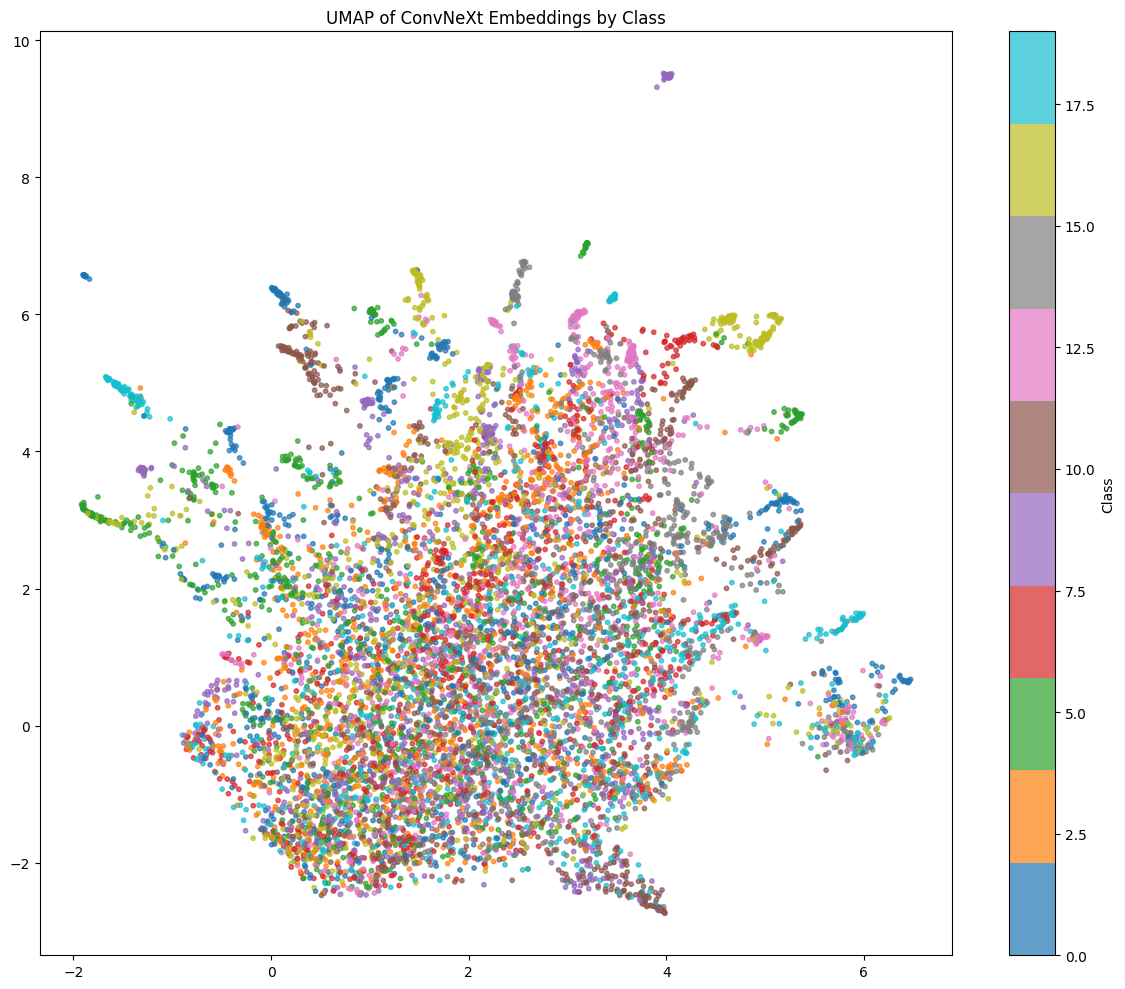

/tmp/ipykernel_939957/3141795934.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('coolwarm', 2),  # Red for unseen, blue for seen


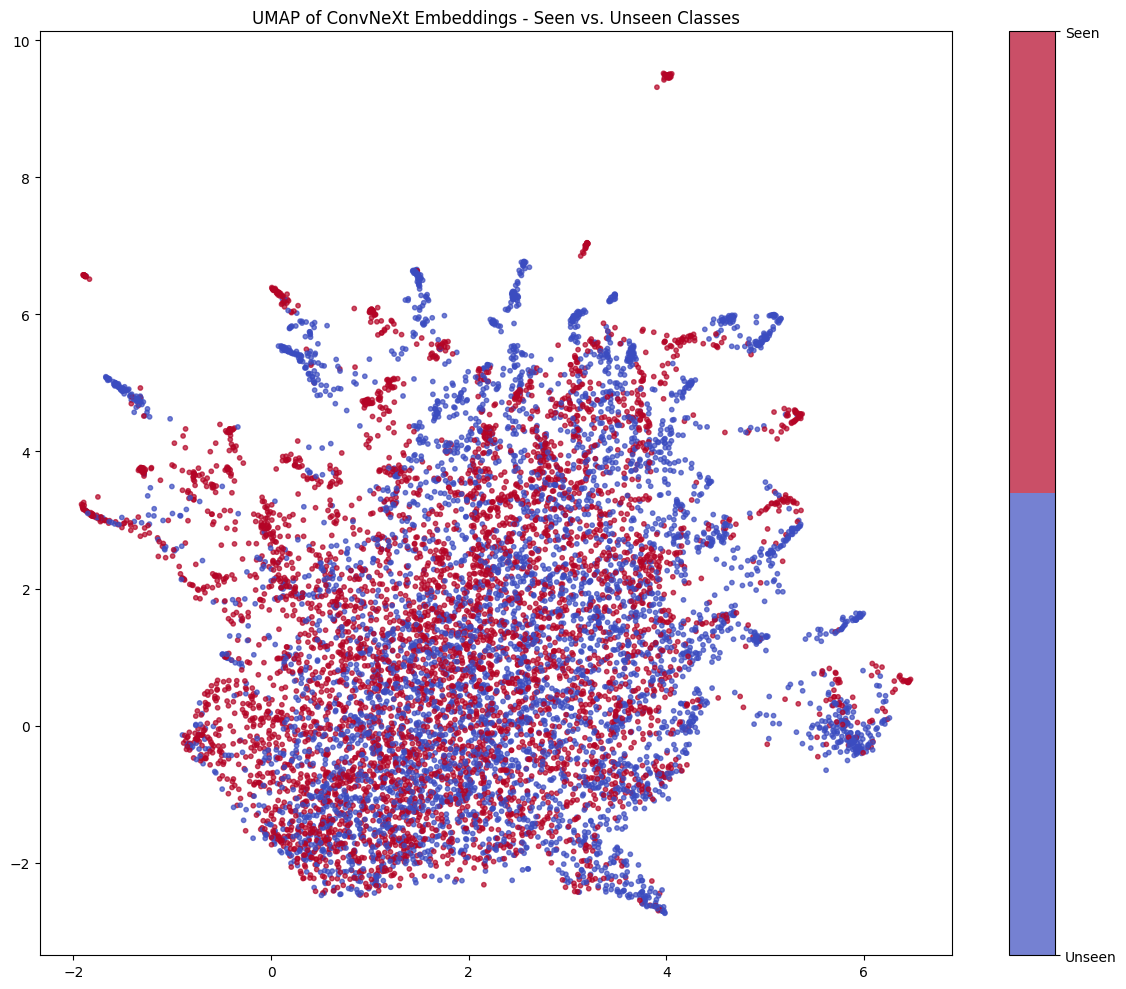

In [7]:
seen_classes = [c for c in range(args.num_base_classes) if c not in args.cls_drop]

# Check if targets are in seen classes
is_seen = np.isin(targets, seen_classes)

# Create UMAP reducer
reducer = umap.UMAP(
    n_neighbors=15,  # Lower for more local structure, higher for more global
    min_dist=0.1,    # Lower for tighter clusters
    n_components=2,  # 2D for visualization
    random_state=42  # For reproducibility
)

# Fit and transform the embeddings
print("Computing UMAP (this may take a minute)...")
embedding = reducer.fit_transform(embeddings)

# Create plots
plt.figure(figsize=(12, 10))

# Color points by class
scatter = plt.scatter(
    embedding[:, 0], 
    embedding[:, 1], 
    c=targets, 
    cmap='tab10', 
    alpha=0.7,
    s=10
)

# Add a colorbar
plt.colorbar(scatter, label='Class')
plt.title('UMAP of ConvNeXt Embeddings by Class')
plt.tight_layout()
plt.savefig('umap_by_class.png', dpi=300)
plt.show()

# If we have seen/unseen class information, create that plot too
if is_seen is not None:
    plt.figure(figsize=(12, 10))
    
    # Create a scatter plot colored by seen/unseen status
    scatter = plt.scatter(
        embedding[:, 0], 
        embedding[:, 1], 
        c=is_seen, 
        cmap=plt.cm.get_cmap('coolwarm', 2),  # Red for unseen, blue for seen
        alpha=0.7,
        s=10
    )
    
    # Add a colorbar with labels
    cbar = plt.colorbar(scatter, ticks=[0, 1])
    cbar.set_ticklabels(['Unseen', 'Seen'])
    
    plt.title('UMAP of ConvNeXt Embeddings - Seen vs. Unseen Classes')
    plt.tight_layout()
    plt.savefig('umap_seen_unseen.png', dpi=300)
    plt.show()

In [20]:
targets.shape

(10000,)

In [27]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

# Set the target class you want to compare
target_class = 3  # Change this to any class from 0-19

for target_class in range(20):
    # Split embeddings into two groups
    embeddings_target = embeddings[targets == target_class]
    embeddings_others = embeddings[targets != target_class]

    # Compute kernel matrices
    gamma = 1.0 / embeddings.shape[1]  # Default gamma: 1/n_features
    K_target = rbf_kernel(embeddings_target, embeddings_target, gamma)
    K_others = rbf_kernel(embeddings_others, embeddings_others, gamma)
    K_between = rbf_kernel(embeddings_target, embeddings_others, gamma)

    # Compute MMD
    mmd_squared = np.mean(K_target) + np.mean(K_others) - 2 * np.mean(K_between)

    print(f"{np.sqrt(mmd_squared)}")

0.11012196920513138
0.11776666574320688
0.08388255845079644
0.0937510331414834
0.12900019603536925
0.09592800578005482
0.11978693275496484
0.10507694513161943
0.09453823599735042
0.09214942275066756
0.1033890147828184
0.09161732747426778
0.09572484295489185
0.10127717065643715
0.1260296022405343
0.11284230131847844
0.08934079242519684
0.11759040236136853
0.10023407362954316
0.10805036317127913
